<center><font color=#555555><font size=6> MAF1731 - Microestructura y Sistemas de trading </font> <br> <br>
    
<center><font color=#555555><font size=5> Ingeniería Financiera </font> <br> <br> <br> <br>

<center><font color=#555555><font size=6> 
                                          I.F. Luis Carlos Alvarado</font> <br> <br>

<center> <font color= #555555> <font size = 4> Abril 2022 </a> | <font color= #555555> <font size = 4> Repositorio: <a href='https://github.com/LuisCarlosAlvarado/myst_lab2_lcag'>Link</a></font>

<hr style="border:0.02in solid gray"> </hr>

<center> <font color= #555555> <font size = 6> Lab 2 </font> <br> <br> <font color= #555555> <font size = 5> Trading Algorítmico  </font>

<font color= #555555> <font size = 4> Abstract </font>

<font color= #6B6B6B> <font size = 3> En este proyecto se creará un sistema de trading, que permita al usuario optimizar la estrategia para escoger la que tenga una mayor o menor función de utilidad (dependiendo el caso).   </font>

# <font color= #6B6B6B> <font size = 6> 1. Introducción </font>

<hr style="border:0.02in solid gray"> </hr>


<font color= #6B6B6B> <font size = 3>Usando el broker online FXCM, obtendremos información del símbolo de nuestra preferencia, para poder aplicar técnicas de trading.<br><br>
    
<font color= #6B6B6B> <font size = 3>El primer paso es descargar información y dividirla en los siguientes periodos.<br><br>

<font color= #6B6B6B> 
A) Pre-pandemia: 31-01-2018 a 31-01-2020.<br>
B) En-pandemia-1: 28-02-2020 a 31-03-2021<br>
C) En-pandemia-2: 01-04-2021 a 31-12-2021<br>

<font color= #6B6B6B> <font size = 3>Ahora, para definir un sistema de trading necesitamos de 4 criterios:
1) Criterio de uso de datos<br>
En este caso, utilizaremos el par "BTC/USD" con temporalidad de 4 horas (debido a que el servidor no deja descargar más datos), y utilizaremos los "Adj. Open" y "Adj. Close", dependiendo de la situación.<br><br>
2) Criterio de generación de señales<br>
Se calcularán 2 promedios móviles exponenciales (EMA), uno de longitud corta, y otro de longitud más larga que el anterior. La señal de compra se dará cuando el EMA corto cruce hacia arriba al EMA largo y la de venta cuando lo cruce hacia abajo.<br>
La lógica detrás de esta técnica nos dice que, cuando EMA corto cruza hacia arriba, significa que la tendencia en el corto plazo está cambiando de direción respecto a la del largo plazo, es este caso, la tendencia es alcista, por eso escogemos esta sencilla técnica.<br><br>
3) Criterio de toma de pérdidas y ganancias<br>
Take profit: Será el momento en el que cerremos la operación con un rendimiento positivo.<br>
Stop loss: Será el momento en el que cerremos la operación con un rendimiento negativo, lo hacemos para no arriesgar el capital.<br><br>
4) Criterio de dimensionamiento de posiciones<br>
Se utilizará todo el capital disponible para esta técnica, y únicamente entraremos a operaciones en largo, es decir, de compra.
<br><br>


In [1]:
import time
inicio = time.time()

In [2]:
import system_desing as sd
import system_optimization as so
import functions as fn
#import data as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Se realiza un gráfico del histórico de los precios para comprobar que han sido descargados correctamente.<br>
### GRÁFICO 1

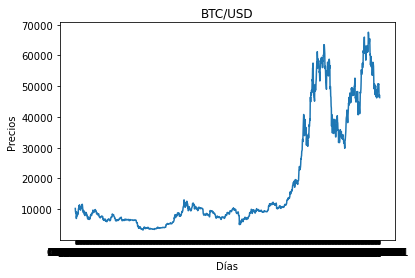

In [3]:
plt.plot(sd.data_ohlc['close'])
plt.title("BTC/USD")
plt.xlabel("Días")
plt.ylabel("Precios")
plt.show()

La primera prueba del proceso de trading se hará con parámetros al azar, y observaremos como se comporta la técnica sin ningún tipo de optimización.

In [4]:
proceso_prueba = sd.proceso_completo(sd.train_ohlc['close'], sd.train_ohlc['open'], .001,\
                short_length=13, long_length=36, take_profit=.01, stop_loss=-.01, capital=20000)
operaciones_prueba= proceso_prueba[2]
rend_operacion_prueba = proceso_prueba[3]
rendimiento_prueba = proceso_prueba[4]
flujo_prueba = proceso_prueba[5]

Este es un DataFrame con los rendimientos obtenidos por algunas operaciones de la prueba.

In [5]:
pd.DataFrame(rendimiento_prueba).head()

,0
0,-0.015641
1,-0.016357
2,0.011442
3,0.021649
4,0.076623


Y así se movió el flujo durante el periodo de entrenamiento sin ninguna optimización.<br>
### GRÁFICO 2

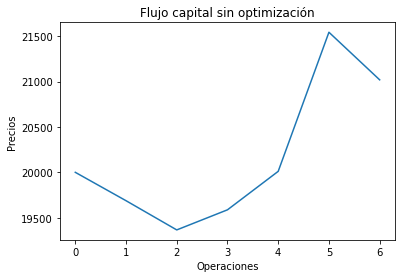

In [6]:
plt.plot(flujo_prueba)
plt.title("Flujo capital sin optimización")
plt.xlabel("Operaciones")
plt.ylabel("Precios")
plt.show()

# <font color= #6B6B6B> <font size = 6> 2. Proceso </font>

<hr style="border:0.02in solid gray"> </hr>

Lo que se busca optimizar con este código es el rendimiento final, la intención es maximizarlo, por lo que el dato que tenga un mayor flujo al final del periodo, será considerado el óptimo.<br><br>

Los parámetros a optimizar son los siguientes:<br><br>

Parámetro: 1<br>
Nombre: Longitud de EMA corta<br>
Descripción: Longitud del promedio móvil exponencial corto, que cruzando hacia arriba nos dará señal de compra.<br>
Tipo de valor: numérico<br>
Rango de valores: 1 - 15<br>
Tamaño de paso mínimo: 1<br><br>

Parámetro: 2<br>
Nombre: Longitud de EMA largo<br>
Descripción: Longitud del promedio móvil exponencial larfo, que cruzando hacia abajo nos dará señal de compra.<br>
Tipo de valor: numérico<br>
Rango de valores: 1 - 15<br>
Tamaño de paso mínimo: 1<br><br>

Parámetro: 3<br>
Nombre: Take profit<br>
Descripción: Rendimiento positivo con el que abandonamos la operación sin esperar una señal de venta.<br>
Tipo de valor: numérico<br>
Rango de valores: $2.5\%$ - $5\%$<br>
Tamaño de paso mínimo: $.5\%$<br><br>

Parámetro: 4<br>
Nombre: Stop loss<br>
Descripción: Rendimiento negativo con el que abandonamos la operación sin esperar una señal de venta.<br>
Tipo de valor: numérico<br>
Rango de valores: $-.5\%$ - $-2.5\%$<br>
Tamaño de paso mínimo: $-.5\%$ <br><br>

El rendimiento máximo obtenido fue de:

In [7]:
so.rend_max

[1.167918260568169]

Y los parámetros fueron los siguientes:<br>
Short length : 1<br>
Long length : 17<br>
Take profit : $3\%$<br>
Stop loss : $-2\%$

In [8]:
so.parametros

[1, 17, 0.030000000000000002, -0.02]

Se obtienen flujos y rendimientos del periodo de entrenamiento pero ahora con los parámetros óptimos

In [9]:
proceso_train = sd.proceso_completo(sd.data_ohlc['close'], sd.data_ohlc['open'], .001,\
                short_length=so.parametros[0], long_length=so.parametros[1],\
                take_profit=so.parametros[2], stop_loss=so.parametros[3], capital=20000)
operaciones_train= proceso_train[2]
rend_operacion_train = proceso_train[3]
rendimiento_train = proceso_train[4]
flujo_train = proceso_train[5]

Movimiento del capital en el periodo.
### Gráfico 3

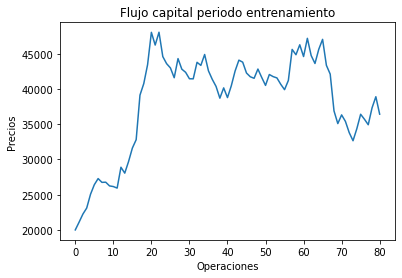

In [10]:
plt.plot(flujo_train)
plt.title("Flujo capital periodo entrenamiento")
plt.xlabel("Operaciones")
plt.ylabel("Precios")
plt.show()

Pips de la divisa con la que se está trabajando.

In [11]:
fn.f_pip_size("btc/USD")

0.01

Duración de cada operación en el periodo.

In [12]:
columnas_tiempos = fn.columnas_tiempos(rend_individual = rend_operacion_train, operaciones=operaciones_train, \
                    take_profit = so.parametros[2], stop_loss = so.parametros[3])
columnas_tiempos.head()

,Tiempo
# Operación,
0,3 days
1,3 days
2,5 days
3,1 days
4,4 days


Profit y pips del periodo, así como la suma acumulada de los mismos, podemos ver que al final del periodo el valor acumulado es positivo.

In [13]:
columnas_pips = fn.f_columnas_pips(pips = fn.f_pip_size("btc/USD"), rendimiento=rendimiento_train)
columnas_pips.head()

,Profit,Pips,Profit_acum,Pip_acum
0,0.055139,0.000551,0.055139,0.000551
1,0.054243,-0.000009,0.109382,0.000542
2,0.038587,-0.000157,0.147968,0.000386
3,0.084415,0.000458,0.232384,0.000844
4,0.054322,-0.000301,0.286706,0.000543


Estadísticas sobre las operaciones realizadas en el periodo.

In [14]:
fn.f_estadísticas_ba(rendimiento_train, operaciones_train, "df_1_tabla")

,Medida,Valor,Descripción
0,Op_totales,80,Operaciones totales
1,Ganadoras,36,Operaciones ganadoras
2,Perdedoras,44,Operaciones perdedoras
3,Mediana (Profit),-0.005814,Mediana de profit de operaciones
4,Mediana (Pips),0.000033,Mediana de pips de operaciones
5,R. efectividad,0.45,Ganadoras Totales/Operaciones Totales
6,R. proporción,0.818182,Ganadoras Totales/Perdedoras Totales


Estadísticas sobre los días con mejor rendimiento de operaciones positivas.

In [15]:
fn.f_estadísticas_ba(rendimiento_train, operaciones_train, "df_2_ranking")

,Rank %
Día,
Saturday,53.33
Friday,53.85
Wednesday,50.00
Thursday,46.15
Tuesday,38.46
Monday,22.22
Sunday,40.00


Evolución del capital durante el periodo, es el gráfico 3 desglozado.

In [16]:
evolucion_capital = fn.f_evolucion_capital(sd.train_ohlc['close'], operaciones_train, rend_operacion_train,\
                                     take_profit=so.parametros[2], stop_loss=so.parametros[3],\
                                        capital =20000, rendimiento= rendimiento_train)
evolucion_capital.tail()

,timestamp,Profit_d,Profit_acum_d
727,2020-01-28 00:00:00,0.035664,43358.365211
728,2020-01-29 00:00:00,0.0,44904.718614
729,2020-01-30 00:00:00,0.0,44904.718614
730,2020-01-31 00:00:00,0.0,44904.718614
731,0.0,0.0,44904.718614


Se calculó:<br>
Sharpe Ratio = $\frac{Rend - R_f}{\sigma Rend}$<br>
Drawdown = Máxima minusvalía registrada durante el periodo.<br>
Drawup = Máxima plusvalía registrada durante el periodo.<br><br>

Con estos elementos nos podemos dar cuenta si el riesgo valió la pena.

In [17]:
fn.f_estadisticas_mad(evolucion_capital)

,0,1
0,Sharpe Ratio Original,-4.06433
1,Sharpe Ratio Actualizado,0
2,DrawDown,-0.074602
3,DrawUp,0.176344


A continuación se realizará exactamente el mismo proceso, ahora en los periodos de validación y prueba, al final se dará una conclusión

In [18]:
proceso_val = sd.proceso_completo(sd.val_ohlc['close'], sd.val_ohlc['open'], .001,\
                short_length=so.parametros[0], long_length=so.parametros[1],\
                take_profit=so.parametros[2], stop_loss=so.parametros[3], capital=20000)
operaciones_val= proceso_val[2]
rend_operacion_val = proceso_val[3]
rendimiento_val = proceso_val[4]
flujo_val = proceso_val[5]

### Gráfico 4

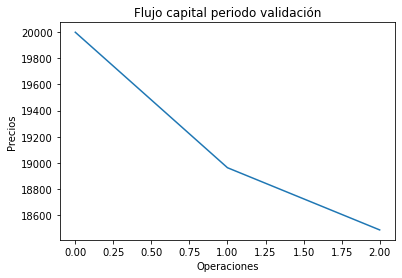

In [19]:
plt.plot(flujo_val)
plt.title("Flujo capital periodo validación")
plt.xlabel("Operaciones")
plt.ylabel("Precios")
plt.show()

In [20]:
columnas_tiempos = fn.columnas_tiempos(rend_individual = rend_operacion_val, operaciones=operaciones_val, \
                    take_profit = so.parametros[2], stop_loss = so.parametros[3])
columnas_tiempos.head()

,Tiempo
# Operación,
0,1 days
1,1 days


In [21]:
columnas_pips = fn.f_columnas_pips(pips = fn.f_pip_size("btc/USD"), rendimiento=rendimiento_val)
columnas_pips.head()

,Profit,Pips,Profit_acum,Pip_acum
0,-0.051868,-0.000519,-0.051868,-0.000519
1,-0.025113,0.000268,-0.076981,-0.000251


In [22]:
evolucion_capital = fn.f_evolucion_capital(sd.val_ohlc['close'], operaciones_val, rend_operacion_val,\
                                     take_profit=so.parametros[2], stop_loss=so.parametros[3],\
                                        capital =20000, rendimiento= rendimiento_val)
evolucion_capital.tail()

,timestamp,Profit_d,Profit_acum_d
55,2021-03-28 00:00:00,0.0,18486.428021
56,2021-03-29 00:00:00,0.0,18486.428021
57,2021-03-30 00:00:00,0.0,18486.428021
58,2021-03-31 00:00:00,0.0,18486.428021
59,0.0,0.0,18486.428021


In [23]:
fn.f_estadisticas_mad(evolucion_capital)

,0,1
0,Sharpe Ratio Original,-6.836001
1,Sharpe Ratio Actualizado,0
2,DrawDown,-0.053262
3,DrawUp,0.0


In [24]:
proceso_test = sd.proceso_completo(sd.test_ohlc['close'], sd.test_ohlc['open'], .001,\
                short_length=so.parametros[0], long_length=so.parametros[1],\
                take_profit=so.parametros[2], stop_loss=so.parametros[3], capital=20000)
operaciones_test= proceso_test[2]
rend_operacion_test = proceso_test[3]
rendimiento_test = proceso_test[4]
flujo_test = proceso_test[5]

### Gráfico 5

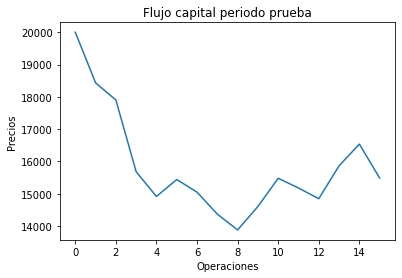

In [25]:
plt.plot(flujo_test)
plt.title("Flujo capital periodo prueba")
plt.xlabel("Operaciones")
plt.ylabel("Precios")
plt.show()

In [26]:
columnas_tiempos = fn.columnas_tiempos(rend_individual = rend_operacion_test, operaciones=operaciones_test, \
                    take_profit = so.parametros[2], stop_loss = so.parametros[3])
columnas_tiempos.head()

,Tiempo
# Operación,
0,4 days
1,5 days
2,1 days
3,1 days
4,1 days


In [27]:
columnas_pips = fn.f_columnas_pips(pips = fn.f_pip_size("btc/USD"), rendimiento=rendimiento_test)
columnas_pips.head()

,Profit,Pips,Profit_acum,Pip_acum
0,-0.078320,-0.000783,-0.078320,-0.000783
1,-0.028751,0.000496,-0.107071,-0.000288
2,-0.124057,-0.000953,-0.231128,-0.001241
3,-0.048787,0.000753,-0.279914,-0.000488
4,0.035143,0.000839,-0.244771,0.000351


In [28]:
fn.f_estadísticas_ba(rendimiento_test, operaciones_test, "df_1_tabla")

,Medida,Valor,Descripción
0,Op_totales,15,Operaciones totales
1,Ganadoras,5,Operaciones ganadoras
2,Perdedoras,10,Operaciones perdedoras
3,Mediana (Profit),-0.025295,Mediana de profit de operaciones
4,Mediana (Pips),-0.000025,Mediana de pips de operaciones
5,R. efectividad,0.333333,Ganadoras Totales/Operaciones Totales
6,R. proporción,0.5,Ganadoras Totales/Perdedoras Totales


In [29]:
fn.f_estadísticas_ba(rendimiento_test, operaciones_test, "df_2_ranking")

,Rank %
Día,
Saturday,50.00
Monday,33.33
Thursday,33.33
Friday,50.00
Wednesday,0.00
Sunday,0.00


In [30]:
evolucion_capital = fn.f_evolucion_capital(sd.test_ohlc['close'], operaciones_test, rend_operacion_test,\
                                     take_profit=so.parametros[2], stop_loss=so.parametros[3],\
                                        capital =20000, rendimiento= rendimiento_test)
evolucion_capital.tail()

,timestamp,Profit_d,Profit_acum_d
271,2021-12-28 00:00:00,0.0,16538.474868
272,2021-12-29 00:00:00,-0.063634,16538.474868
273,2021-12-30 00:00:00,0.0,15486.067672
274,2021-12-31 00:00:00,0.0,15486.067672
275,0.0,0.0,15486.067672


In [31]:
fn.f_estadisticas_mad(evolucion_capital)

,0,1
0,Sharpe Ratio Original,-3.792428
1,Sharpe Ratio Actualizado,0
2,DrawDown,-0.132454
3,DrawUp,0.066327


Número de iteraciones que se realizaron en la optimizacón.

In [32]:
fn.metrica_optimizacion(range(1,15), range(15,30), np.arange(.025,.055,.005), np.arange(-.005,-.03,-.005))

6300

Tiempo que tardó en correr el código.

In [33]:
print("El código tarda en correr", (time.time() - inicio)/60, "minutos" )

El código tarda en correr 5.303676931063334 minutos


# <font color= #6B6B6B> <font size = 6> 3. Conclusión </font>

<hr style="border:0.02in solid gray"> </hr>

En los periodos de validación y prueba estamos obteniendo rendimientos negativos con los parámetros óptimos, hay que tener en cuenta que el activo con el que se está trabajando ha tenido periodos de crecimientos excesivos, y ese puede ser un motivo por el cuál los parámetros no funcionan para periodos más planos.<br><br>

Lo correcto sería ampliar los periodos para realizar un entrenamiento en periodos más "normales" en cuanto a las variaciones del precio.<br><br>

Esto también demuestra lo irracional que es el mercado de las cryptos, tiene periodos bastante explosivos y después se regulan. Habrá que ampliar la búsqueda para encontrar parámetros que permitan aprovechar cuando el mercado actúa irracional y cuando tiene un comportamiento más adecuado. O bien se podrían aplicar estrategias distintas dependiendo del movimiento del mercado, el detalle ahora sería identificar cuando estos movimientos comiencen.